In [280]:
import pandas as pd
import geopandas as gpd
from geocube.api.core import make_geocube
from geocube.rasterize import rasterize_image
from functools import partial
from rasterio.enums import MergeAlg
from shapely.geometry import LineString
import matplotlib as plt
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt2
import rasterio as rio
import numpy as np
from scipy import stats
import requests
from io import BytesIO
from zipfile import ZipFile
from functools import partial
import pygeohash as gh
from shapely.geometry import Polygon

In [281]:
url = 'https://raw.githubusercontent.com/IsamAljawarneh/datasets/master/data/NYC_AQ.csv'
NYC_AQ = pd.read_csv(url)

url = 'https://raw.githubusercontent.com/IsamAljawarneh/datasets/master/data/nyc_polygon.geojson'
NYC_geojson = gpd.read_file(url)


In [282]:
NYC_AQ

,SensorID,time,latitude,longitude,bin0,bin1,bin2,bin3,bin4,bin5,...,bin17,bin18,bin19,bin20,bin21,bin22,bin23,temperature,humidity,pm25
0,NYCP2_CS01A,1631277304,40.847672,-73.869316,11,1,1,0,0,0,...,0,0,0,0,0,0,0,23.7,57.3,4.508813
1,NYCP2_CS01A,1631277308,40.847668,-73.869316,22,4,1,0,0,2,...,0,0,0,0,0,0,0,23.7,57.8,5.462420
2,NYCP2_CS01A,1631277313,40.847649,-73.869362,40,1,1,0,0,1,...,0,0,0,0,0,0,0,23.7,57.8,5.154881
3,NYCP2_CS01A,1631277318,40.847649,-73.869362,26,1,0,0,0,0,...,0,0,0,0,0,0,0,23.6,57.6,4.508813
4,NYCP2_CS01A,1631277323,40.847649,-73.869362,44,4,0,1,0,0,...,0,0,0,0,0,0,0,23.6,57.5,5.539503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169994,NYCP2_CS03A,1631457109,40.823353,-73.890488,115,11,2,0,1,0,...,0,0,0,0,0,0,0,24.6,54.8,5.460360
169995,NYCP2_CS03A,1631457114,40.823349,-73.890480,132,8,2,0,0,0,...,0,0,0,0,0,0,0,24.6,54.8,5.298209
169996,NYCP2_CS03A,1631457119,40.823349,-73.890480,147,14,0,0,0,0,...,0,0,0,0,0,0,0,24.6,54.8,6.470661
169997,NYCP2_CS03A,1631457124,40.823345,-73.890488,121,8,2,0,1,1,...,0,0,0,0,0,0,0,24.6,54.6,6.424142


In [283]:
print(NYC_geojson.head())

      neighborhood boroughCode        borough  \
0         Allerton           2          Bronx   
1  Alley Pond Park           4         Queens   
2    Arden Heights           5  Staten Island   
3        Arlington           5  Staten Island   
4         Arrochar           5  Staten Island   

                                                 @id  \
0  http://nyc.pediacities.com/Resource/Neighborho...   
1  http://nyc.pediacities.com/Resource/Neighborho...   
2  http://nyc.pediacities.com/Resource/Neighborho...   
3  http://nyc.pediacities.com/Resource/Neighborho...   
4  http://nyc.pediacities.com/Resource/Neighborho...   

                                            geometry  
0  POLYGON ((-73.84860 40.87167, -73.84582 40.870...  
1  POLYGON ((-73.74333 40.73888, -73.74371 40.739...  
2  POLYGON ((-74.16983 40.56108, -74.16982 40.561...  
3  POLYGON ((-74.15975 40.64142, -74.15998 40.641...  
4  POLYGON ((-74.06078 40.59319, -74.06079 40.593...  


In [284]:
columns_to_keep = ['latitude', 'longitude', 'pm25']
NYC_AQ = NYC_AQ[columns_to_keep]

NYC_AQ = NYC_AQ[(NYC_AQ['latitude'] != 0) & (NYC_AQ['longitude'] != 0)]

NYC_AQ['longitude'] = pd.to_numeric(NYC_AQ['longitude'])
NYC_AQ['latitude'] = pd.to_numeric(NYC_AQ['latitude'])

print(NYC_AQ)

         latitude  longitude      pm25
0       40.847672 -73.869316  4.508813
1       40.847668 -73.869316  5.462420
2       40.847649 -73.869362  5.154881
3       40.847649 -73.869362  4.508813
4       40.847649 -73.869362  5.539503
...           ...        ...       ...
169994  40.823353 -73.890488  5.460360
169995  40.823349 -73.890480  5.298209
169996  40.823349 -73.890480  6.470661
169997  40.823345 -73.890488  6.424142
169998  40.823338 -73.890488  6.526187

[169999 rows x 3 columns]


In [285]:
geohash_precision = 7
NYC_AQ['geohash']=NYC_AQ.apply(lambda x: gh.encode(x.latitude, x.longitude, precision=geohash_precision), axis=1)
NYC_AQ.head()

,latitude,longitude,pm25,geohash
0,40.847672,-73.869316,4.508813,dr72rh4
1,40.847668,-73.869316,5.462420,dr72rh4
2,40.847649,-73.869362,5.154881,dr72rh1
3,40.847649,-73.869362,4.508813,dr72rh1
4,40.847649,-73.869362,5.539503,dr72rh1


In [286]:
avg_pm25 = NYC_AQ.groupby('geohash').agg({'pm25': 'mean'}).reset_index()
avg_pm25.rename(columns={'pm25': 'avg_pm25'}, inplace=True)
avg_pm25

,geohash,avg_pm25
0,dr5rte6,3.187280
1,dr5ry2s,3.084182
2,dr5rz97,10.620296
3,dr5rz9e,10.875361
4,dr72j8q,3.084182
...,...,...
1163,dr78856,2.726714
1164,dr78858,3.578802
1165,dr7885b,3.143590
1166,dr7885h,2.725700


In [287]:
NYC_AQ = NYC_AQ.merge(avg_pm25, on='geohash', how='left')
NYC_AQ

,latitude,longitude,pm25,geohash,avg_pm25
0,40.847672,-73.869316,4.508813,dr72rh4,4.077038
1,40.847668,-73.869316,5.462420,dr72rh4,4.077038
2,40.847649,-73.869362,5.154881,dr72rh1,3.997004
3,40.847649,-73.869362,4.508813,dr72rh1,3.997004
4,40.847649,-73.869362,5.539503,dr72rh1,3.997004
...,...,...,...,...,...
169994,40.823353,-73.890488,5.460360,dr72nxd,5.708895
169995,40.823349,-73.890480,5.298209,dr72nxd,5.708895
169996,40.823349,-73.890480,6.470661,dr72nxd,5.708895
169997,40.823345,-73.890488,6.424142,dr72nxd,5.708895


In [288]:
NYC_AQ = gpd.GeoDataFrame(NYC_AQ)
NYC_AQ.head()

,latitude,longitude,pm25,geohash,avg_pm25
0,40.847672,-73.869316,4.508813,dr72rh4,4.077038
1,40.847668,-73.869316,5.462420,dr72rh4,4.077038
2,40.847649,-73.869362,5.154881,dr72rh1,3.997004
3,40.847649,-73.869362,4.508813,dr72rh1,3.997004
4,40.847649,-73.869362,5.539503,dr72rh1,3.997004


In [289]:
NYC_AQ = gpd.GeoDataFrame(NYC_AQ, geometry = gpd.points_from_xy(x=NYC_AQ['longitude'], y=NYC_AQ['latitude']))
NYC_AQ = NYC_AQ.set_crs('EPSG:4326')
NYC_AQ



,latitude,longitude,pm25,geohash,avg_pm25,geometry
0,40.847672,-73.869316,4.508813,dr72rh4,4.077038,POINT (-73.86932 40.84767)
1,40.847668,-73.869316,5.462420,dr72rh4,4.077038,POINT (-73.86932 40.84767)
2,40.847649,-73.869362,5.154881,dr72rh1,3.997004,POINT (-73.86936 40.84765)
3,40.847649,-73.869362,4.508813,dr72rh1,3.997004,POINT (-73.86936 40.84765)
4,40.847649,-73.869362,5.539503,dr72rh1,3.997004,POINT (-73.86936 40.84765)
...,...,...,...,...,...,...
169994,40.823353,-73.890488,5.460360,dr72nxd,5.708895,POINT (-73.89049 40.82335)
169995,40.823349,-73.890480,5.298209,dr72nxd,5.708895,POINT (-73.89048 40.82335)
169996,40.823349,-73.890480,6.470661,dr72nxd,5.708895,POINT (-73.89048 40.82335)
169997,40.823345,-73.890488,6.424142,dr72nxd,5.708895,POINT (-73.89049 40.82335)


In [290]:
def decode_geohash(geohash):
    """Decode the geohash to its bounding box (longitude and latitude ranges)."""

    # Geohash character-to-binary mapping
    base32_map = '0123456789bcdefghjkmnpqrstuvwxyz'
    base32_dict = {char: "{:05b}".format(i) for i, char in enumerate(base32_map)}

    # Split geohash into bits for longitude and latitude
    bits = ''.join(base32_dict[c] for c in geohash)
    lon_bits = bits[::2]
    lat_bits = bits[1::2]

    # Function to decode bits to a range
    def decode_range(bits, range_min, range_max):
        for bit in bits:
            mid = (range_min + range_max) / 2
            if bit == '1':
                range_min = mid
            else:
                range_max = mid
        return (range_min, range_max)

    # Decode longitude and latitude ranges
    lon_range = decode_range(lon_bits, -180, 180)
    lat_range = decode_range(lat_bits, -90, 90)

    # Return the bounding box as a dictionary
    return {
        'w': lon_range[0],
        'e': lon_range[1],
        's': lat_range[0],
        'n': lat_range[1],
    }



# Now 'gdf' contains polygons instead of points
print(temp['geometry'])

0         POLYGON ((-73.86932373046875 40.84716796875, -...
1         POLYGON ((-73.86932373046875 40.84716796875, -...
2         POLYGON ((-73.87069702148438 40.84716796875, -...
3         POLYGON ((-73.87069702148438 40.84716796875, -...
4         POLYGON ((-73.87069702148438 40.84716796875, -...
                                ...                        
169994    POLYGON ((-73.89129638671875 40.82244873046875...
169995    POLYGON ((-73.89129638671875 40.82244873046875...
169996    POLYGON ((-73.89129638671875 40.82244873046875...
169997    POLYGON ((-73.89129638671875 40.82244873046875...
169998    POLYGON ((-73.89129638671875 40.82244873046875...
Name: geohash, Length: 169999, dtype: object


In [291]:
temp['bbox'] = NYC_AQ['geohash'].apply(decode_geohash)
# Convert bounding boxes to polygons
temp['geometry'] = temp['bbox'].apply(lambda b: Polygon([
    (b['w'], b['s']),
    (b['w'], b['n']),
    (b['e'], b['n']),
    (b['e'], b['s'])
]))
NYC_AQ = gpd.GeoDataFrame(NYC_AQ, geometry = temp['geometry'])
NYC_AQ

,latitude,longitude,pm25,geohash,avg_pm25,geometry
0,40.847672,-73.869316,4.508813,dr72rh4,4.077038,"POLYGON ((-73.86932 40.84717, -73.86932 40.848..."
1,40.847668,-73.869316,5.462420,dr72rh4,4.077038,"POLYGON ((-73.86932 40.84717, -73.86932 40.848..."
2,40.847649,-73.869362,5.154881,dr72rh1,3.997004,"POLYGON ((-73.87070 40.84717, -73.87070 40.848..."
3,40.847649,-73.869362,4.508813,dr72rh1,3.997004,"POLYGON ((-73.87070 40.84717, -73.87070 40.848..."
4,40.847649,-73.869362,5.539503,dr72rh1,3.997004,"POLYGON ((-73.87070 40.84717, -73.87070 40.848..."
...,...,...,...,...,...,...
169994,40.823353,-73.890488,5.460360,dr72nxd,5.708895,"POLYGON ((-73.89130 40.82245, -73.89130 40.823..."
169995,40.823349,-73.890480,5.298209,dr72nxd,5.708895,"POLYGON ((-73.89130 40.82245, -73.89130 40.823..."
169996,40.823349,-73.890480,6.470661,dr72nxd,5.708895,"POLYGON ((-73.89130 40.82245, -73.89130 40.823..."
169997,40.823345,-73.890488,6.424142,dr72nxd,5.708895,"POLYGON ((-73.89130 40.82245, -73.89130 40.823..."


In [292]:
NYC_AQ_geojson = gpd.sjoin(NYC_AQ, NYC_geojson, predicate="within")
NYC_AQ_geojson

,latitude,longitude,pm25,geohash,avg_pm25,geometry,index_right,neighborhood,boroughCode,borough,@id
249,40.745548,-73.844963,12.031301,dr5rz9e,10.875361,"POLYGON ((-73.84598 40.74554, -73.84598 40.746...",104,Flushing Meadows Corona Park,4,Queens,http://nyc.pediacities.com/Resource/Neighborho...
250,40.745548,-73.844963,6.728364,dr5rz9e,10.875361,"POLYGON ((-73.84598 40.74554, -73.84598 40.746...",104,Flushing Meadows Corona Park,4,Queens,http://nyc.pediacities.com/Resource/Neighborho...
251,40.745548,-73.844963,12.059568,dr5rz9e,10.875361,"POLYGON ((-73.84598 40.74554, -73.84598 40.746...",104,Flushing Meadows Corona Park,4,Queens,http://nyc.pediacities.com/Resource/Neighborho...
252,40.745548,-73.844963,12.682212,dr5rz9e,10.875361,"POLYGON ((-73.84598 40.74554, -73.84598 40.746...",104,Flushing Meadows Corona Park,4,Queens,http://nyc.pediacities.com/Resource/Neighborho...
253,40.745430,-73.844795,12.593311,dr5rz97,10.620296,"POLYGON ((-73.84598 40.74417, -73.84598 40.745...",104,Flushing Meadows Corona Park,4,Queens,http://nyc.pediacities.com/Resource/Neighborho...
...,...,...,...,...,...,...,...,...,...,...,...
169994,40.823353,-73.890488,5.460360,dr72nxd,5.708895,"POLYGON ((-73.89130 40.82245, -73.89130 40.823...",176,Longwood,2,Bronx,http://nyc.pediacities.com/Resource/Neighborho...
169995,40.823349,-73.890480,5.298209,dr72nxd,5.708895,"POLYGON ((-73.89130 40.82245, -73.89130 40.823...",176,Longwood,2,Bronx,http://nyc.pediacities.com/Resource/Neighborho...
169996,40.823349,-73.890480,6.470661,dr72nxd,5.708895,"POLYGON ((-73.89130 40.82245, -73.89130 40.823...",176,Longwood,2,Bronx,http://nyc.pediacities.com/Resource/Neighborho...
169997,40.823345,-73.890488,6.424142,dr72nxd,5.708895,"POLYGON ((-73.89130 40.82245, -73.89130 40.823...",176,Longwood,2,Bronx,http://nyc.pediacities.com/Resource/Neighborho...


In [293]:
# sampled_geohash_data = NYC_AQ_geojson.groupby('geohash').apply(lambda x: x.sample(frac=0.6))
# sampled_geohash_data

In [294]:
print(len(NYC_AQ['geohash'].unique()))

1168


In [295]:
print(NYC_AQ['geohash'].value_counts().head(70))


geohash
dr72r5c    18297
dr72nqu     9450
dr72rh1     9425
dr72njf     6181
dr72r59     4293
           ...  
dr72q2h      438
dr72nxc      432
dr72nxf      420
dr72jvu      419
dr72jvd      402
Name: count, Length: 70, dtype: int64


In [302]:
print(NYC_AQ['avg_pm25'].max())
print(NYC_AQ['avg_pm25'].min())

12.31804457
2.0657861653999996


In [297]:
NYC_AQ_geojson = NYC_AQ_geojson.to_crs('EPSG:32618')

In [298]:
unique_polygon = NYC_AQ.drop_duplicates(subset='geometry')
unique_polygon

,latitude,longitude,pm25,geohash,avg_pm25,geometry
0,40.847672,-73.869316,4.508813,dr72rh4,4.077038,"POLYGON ((-73.86932 40.84717, -73.86932 40.848..."
2,40.847649,-73.869362,5.154881,dr72rh1,3.997004,"POLYGON ((-73.87070 40.84717, -73.87070 40.848..."
84,40.847164,-73.869812,5.343150,dr72r5c,4.261263,"POLYGON ((-73.87070 40.84579, -73.87070 40.847..."
205,40.845779,-73.870430,4.643380,dr72r59,4.054299,"POLYGON ((-73.87070 40.84442, -73.87070 40.845..."
249,40.745548,-73.844963,12.031301,dr5rz9e,10.875361,"POLYGON ((-73.84598 40.74554, -73.84598 40.746..."
...,...,...,...,...,...,...
161455,40.854622,-73.923546,2.367734,dr72mv6,2.367734,"POLYGON ((-73.92426 40.85403, -73.92426 40.855..."
161459,40.839794,-73.848595,3.464629,dr72rd9,3.464629,"POLYGON ((-73.84872 40.83893, -73.84872 40.840..."
161460,40.860912,-73.845108,3.498658,dr72rwe,3.498658,"POLYGON ((-73.84598 40.86090, -73.84598 40.862..."
161461,40.890411,-73.848419,3.309879,dr72xec,3.309879,"POLYGON ((-73.84872 40.88974, -73.84872 40.891..."


In [309]:
AQ_NYC_raster = make_geocube(
        vector_data = unique_polygon,
        measurements = ['avg_pm25'],
        resolution = (-2, 2),
        rasterize_function=partial(rasterize_image, merge_alg=MergeAlg.add),
        fill= 0,
        output_crs="EPSG:32618")

In [310]:
AQ_NYC_raster["avg_pm25"].rio.to_raster(r'./output_samples/AQ_NYC_raster_overlayed_avg_pm25_geohash_7_1.tiff')

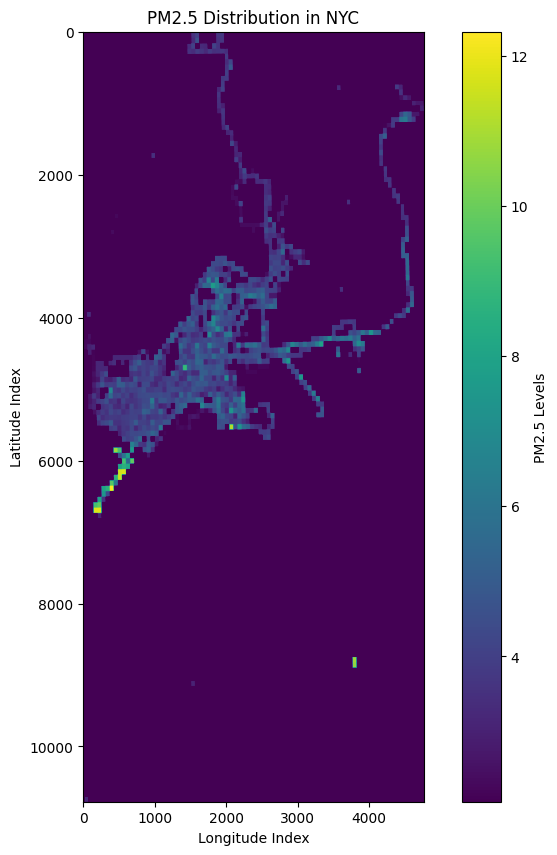

In [315]:
# Load the raster file
with rio.open("./output_samples/AQ_NYC_raster_overlayed_avg_pm25_geohash_7_2.tiff") as src:
    data = src.read(1)  # read the first band

# Set up the figure
plt2.figure(figsize=(10, 10))

# Display the raster data with a colormap
plt2.imshow(data, cmap='viridis', vmin=2.0657861653999996, vmax=12.31804457)  # set the range of the colormap
plt2.colorbar(label='PM2.5 Levels')  # add a color bar

# Add titles and labels if necessary
plt2.title('PM2.5 Distribution in NYC')
plt2.xlabel('Longitude Index')
plt2.ylabel('Latitude Index')

# Show the plot
plt2.show()

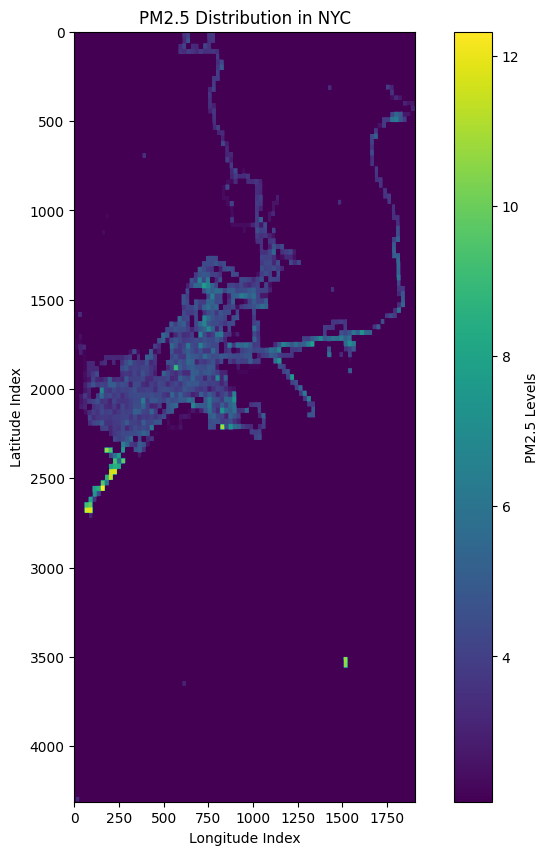

In [316]:
# Load the raster file
with rio.open("./output_samples/AQ_NYC_raster_overlayed_avg_pm25_geohash_7_5.tiff") as src:
    data = src.read(1)  # read the first band

# Set up the figure
plt2.figure(figsize=(10, 10))

# Display the raster data with a colormap
plt2.imshow(data, cmap='viridis', vmin=2.0657861653999996, vmax=12.31804457)  # set the range of the colormap
plt2.colorbar(label='PM2.5 Levels')  # add a color bar

# Add titles and labels if necessary
plt2.title('PM2.5 Distribution in NYC')
plt2.xlabel('Longitude Index')
plt2.ylabel('Latitude Index')

# Show the plot
plt2.show()

In [ ]:
landsat = rio.open("./output_samples/AQ_NYC_raster_overlayed_pm25.tiff")

In [ ]:
# The CRS
landsat.crs

CRS.from_epsg(32618)

In [ ]:
# The bounds
landsat.bounds

BoundingBox(left=589990.0, bottom=4507295.0, right=599345.0, top=4528735.0)

In [ ]:
# The number of bands available
landsat.count

1

In [ ]:
# The band numbers that are available
landsat.indexes

(1,)

In [ ]:
# Number of pixels in the x and y directions
landsat.shape

(4288, 1871)

In [ ]:
# The 6 parameters that map from pixel to real space
landsat.transform

Affine(5.0, 0.0, 589990.0,
       0.0, -5.0, 4528735.0)